# ***Exploring the network of books***

Notebook created by: Eline Evje, Malin Haugland Høli and Ina Martini as group 54

This notebook contains explainer code for the analyses done as part of the project assignment. The group was interested in looking deeper into people's reading habits.

## ***Imports***

In [73]:
import random
import pandas as pd
import numpy as np
import os
import kagglehub
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


## ***1. Download dataset from Kaggle***

The datasets used in the analyses has been retrieved from Kaggle.com. There is a separate dataset for book ratings and book details.

In [74]:
# Download latest version
path = kagglehub.dataset_download("mohamedbakhet/amazon-books-reviews")

print("Path to dataset files:", path)

files = os.listdir(path)
print("\nFiles in dataset folder:", files)

Path to dataset files: C:\Users\Malin Haugland Høli\.cache\kagglehub\datasets\mohamedbakhet\amazon-books-reviews\versions\1

Files in dataset folder: ['books_data.csv', 'Books_rating.csv']


### 1.1 Merge dataframes

In [75]:
path_to_books_data = os.path.join(path, "books_data.csv")
books_data = pd.read_csv(path_to_books_data)

path_to_books_rating = os.path.join(path, "Books_rating.csv")
books_rating = pd.read_csv(path_to_books_rating)

books_df = pd.merge(books_data, books_rating, on="Title", how="inner") # to include only books present in both datasets
books_df.head(3)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,1882931173,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."


## ***2. Preprocessing and cleaning***

The group decided to do some preprocessing and cleaning steps to support the analyses. This included dropping columns not relevant for the research questions, removing nan values and filtering the data by a specific time range. 2000-2010 was considered a decent time period to focus on. **write more**

### 2.1 Drop less important columns for the analyses

In [76]:
books_df = books_df.drop(columns=["image", "previewLink", "authors", "infoLink", "publisher", "profileName"])
books_df.head(5)

,Title,description,publishedDate,categories,ratingsCount,Id,Price,User_id,review/helpfulness,review/score,review/time,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,1996,['Comics & Graphic Novels'],NaN,1882931173,NaN,AVCGYZL8FQQTD,7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,2005-01-01,['Biography & Autobiography'],NaN,0826414346,NaN,A30TK6U7DNS82R,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,2005-01-01,['Biography & Autobiography'],NaN,0826414346,NaN,A3UH4UZ4RSVO82,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,2005-01-01,['Biography & Autobiography'],NaN,0826414346,NaN,A2MVUWT453QH61,7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,2005-01-01,['Biography & Autobiography'],NaN,0826414346,NaN,A22X4XUPKF66MR,3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


### 2.2 Remove NaN values

In [77]:
print("Shape before dropping NaN values:", books_df.shape)
books_df = books_df.dropna()
print("Shape after dropping NaN values:", books_df.shape)

Shape before dropping NaN values: (3000000, 13)
Shape after dropping NaN values: (183487, 13)


### 2.3 Change date format and filter between 2000 and 2010

In [78]:
books_df["review/time"] = pd.to_datetime(books_df["review/time"], unit="s")

# Check the earliest and latest review dates
print("Earliest review date:", books_df["review/time"].min(), "→ Latest review date:", books_df["review/time"].max())

start_date = "2000-01-01"
end_date = "2010-12-31"

books_df_filtered = books_df[(books_df["review/time"] >= start_date) & (books_df["review/time"] <= end_date)]
books_df_filtered = books_df_filtered.reset_index(drop=True)

print(f"Number of original rows: {len(books_df):,}")
print(f"Number of filtered rows (2000–2010): {len(books_df_filtered):,}")

books_df = books_df_filtered
books_df.head(5)

Earliest review date: 1996-11-18 00:00:00 → Latest review date: 2013-03-04 00:00:00
Number of original rows: 183,487
Number of filtered rows (2000–2010): 135,691


,Title,description,publishedDate,categories,ratingsCount,Id,Price,User_id,review/helpfulness,review/score,review/time,review/summary,review/text
0,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,['Religion'],5.0,0802841899,25.97,ARI272XF8TOL4,74/81,5.0,2000-04-11,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...
1,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,['Religion'],5.0,0802841899,25.97,ANX3DDV12ZRRU,2/3,4.0,2010-11-17,An Excellent Presentation of the Beliefs of th...,This book is a continual resource. It is so bi...
2,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,['Religion'],5.0,0802841899,25.97,A2H2LORTA5EZY2,3/5,4.0,2010-02-15,Christ is Lord,This is a very useful and thorough text book. ...
3,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,2018-09-20,['History'],1.0,0887402216,34.95,A30IUAABSEHEPI,9/9,3.0,2003-06-19,The Battleship Bismarck reviewed,This book is both a history and a photo album ...
4,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,2018-09-20,['History'],1.0,0887402216,34.95,A29SCEAL3JPMYW,0/0,4.0,2008-08-04,nice historical pictures,I like this book first one I've seen with so m...


### 2.4 Remove brackets and quotes on the 'categories' column

In [79]:
books_df['categories'] = (
    books_df['categories']
    .astype(str)
    .str.replace(r"[\[\]']", '', regex=True)
    .str.strip()
)
books_df.head(5)

,Title,description,publishedDate,categories,ratingsCount,Id,Price,User_id,review/helpfulness,review/score,review/time,review/summary,review/text
0,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,Religion,5.0,0802841899,25.97,ARI272XF8TOL4,74/81,5.0,2000-04-11,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...
1,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,Religion,5.0,0802841899,25.97,ANX3DDV12ZRRU,2/3,4.0,2010-11-17,An Excellent Presentation of the Beliefs of th...,This book is a continual resource. It is so bi...
2,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,1996,Religion,5.0,0802841899,25.97,A2H2LORTA5EZY2,3/5,4.0,2010-02-15,Christ is Lord,This is a very useful and thorough text book. ...
3,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,2018-09-20,History,1.0,0887402216,34.95,A30IUAABSEHEPI,9/9,3.0,2003-06-19,The Battleship Bismarck reviewed,This book is both a history and a photo album ...
4,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,2018-09-20,History,1.0,0887402216,34.95,A29SCEAL3JPMYW,0/0,4.0,2008-08-04,nice historical pictures,I like this book first one I've seen with so m...


## ***3. The book-book network***

This step constructs the core network used for further analysis. First, a bipartite graph is created between user and books. The graph is then projected into the book layer, producing a weighted book-book network.

In [80]:
# Build bipartite graph
B = nx.Graph()
B.add_nodes_from(books_df["Title"], bipartite="books")
B.add_nodes_from(books_df["User_id"], bipartite="users")

edges = list(zip(books_df["User_id"], books_df["Title"]))
B.add_edges_from(edges)

# Project onto book layer
book_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == "books"]
book_graph = bipartite.weighted_projected_graph(B, book_nodes)

print("Projected book–book graph:", book_graph.number_of_nodes(), "nodes,", book_graph.number_of_edges(), "edges")

# ---- Extract GCC ----
gcc_nodes = max(nx.connected_components(book_graph), key=len)
G_gcc = book_graph.subgraph(gcc_nodes).copy()

print("GCC:", G_gcc.number_of_nodes(), "nodes,", G_gcc.number_of_edges(), "edges")

Projected book–book graph: 10192 nodes, 265545 edges
GCC: 7093 nodes, 265435 edges


**Giant connected component**

The network is visualized using the giant connected component.

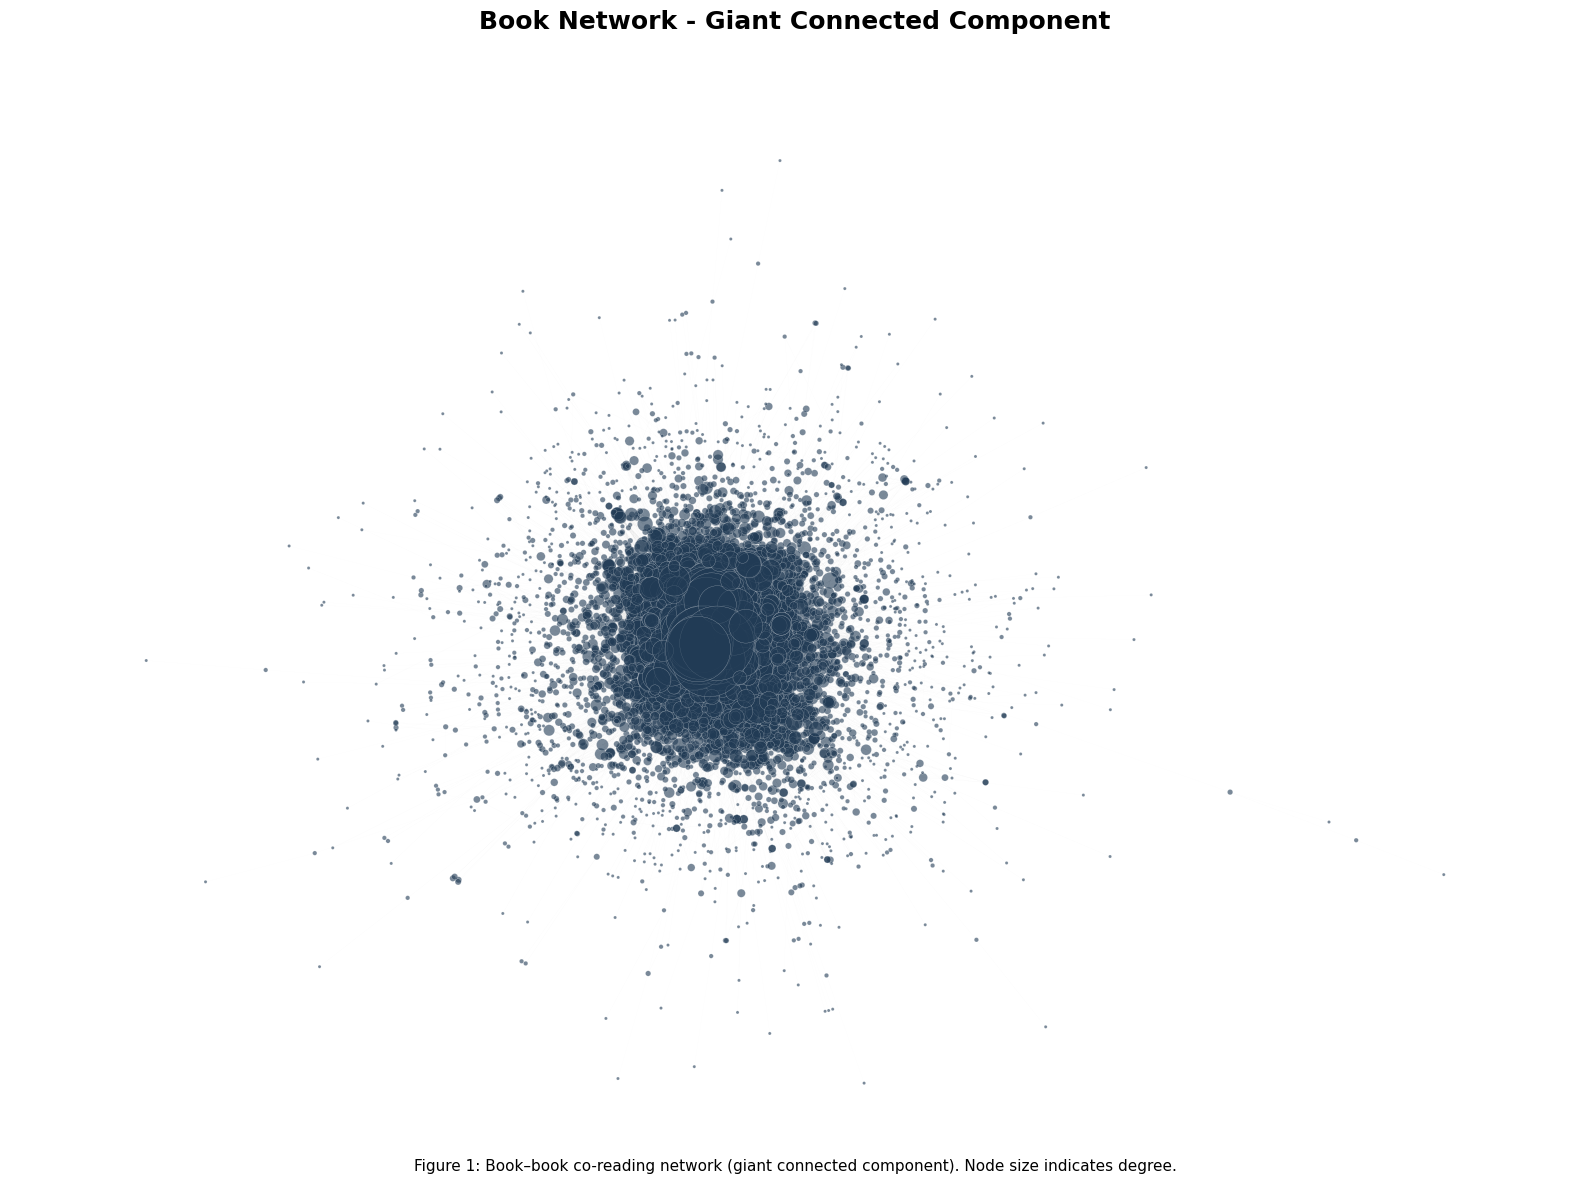

In [81]:
pos = nx.spring_layout(
    G_gcc,
    k=2 / np.sqrt(G_gcc.number_of_nodes()),
    iterations=50,
    seed=42,
    scale=10.0
)

# Node sizes based on degree (smaller than backbone to reduce clutter)
degrees = dict(G_gcc.degree())
node_sizes = [degrees[node] * 5 for node in G_gcc.nodes()]

plt.figure(figsize=(16, 12), facecolor='white')
plt.title("Book Network - Giant Connected Component",
          fontsize=18, fontweight='bold', pad=25)

# Draw edges (very transparent because there are many)
nx.draw_networkx_edges(
    G_gcc, pos,
    alpha=0.02,
    edge_color='dimgray',
    width=0.2
)

# Draw nodes
nx.draw_networkx_nodes(
    G_gcc, pos,
    node_size=node_sizes,
    alpha=0.6,
    edgecolors='white',
    node_color='#213b55',
    linewidths=0.2
)

plt.figtext(
    0.5, 0.02,
    "Figure 1: Book–book co-reading network (giant connected component). Node size indicates degree.",
    wrap=True, ha="center", fontsize=11
)

plt.axis('off')
plt.tight_layout()
plt.show()

*Figure 1* shows the giant connected component of the book co-reading network, where each node represents a book and edges indicate that the same users have reviewed both books. Overall, the structure reflects a strongly interconnected reading network with clear hubs of shared audience interest.

### 3.1 Network Backbone

Backbone extraction highlights the most statistically meaningful co-reading connections in the book network by filtering out weaker, potentially noisy edges.

Input graph (GCC): 7093 nodes, 265435 edges
Backbone: 2414 nodes, 12094 edges
Edges removed: 95.4%


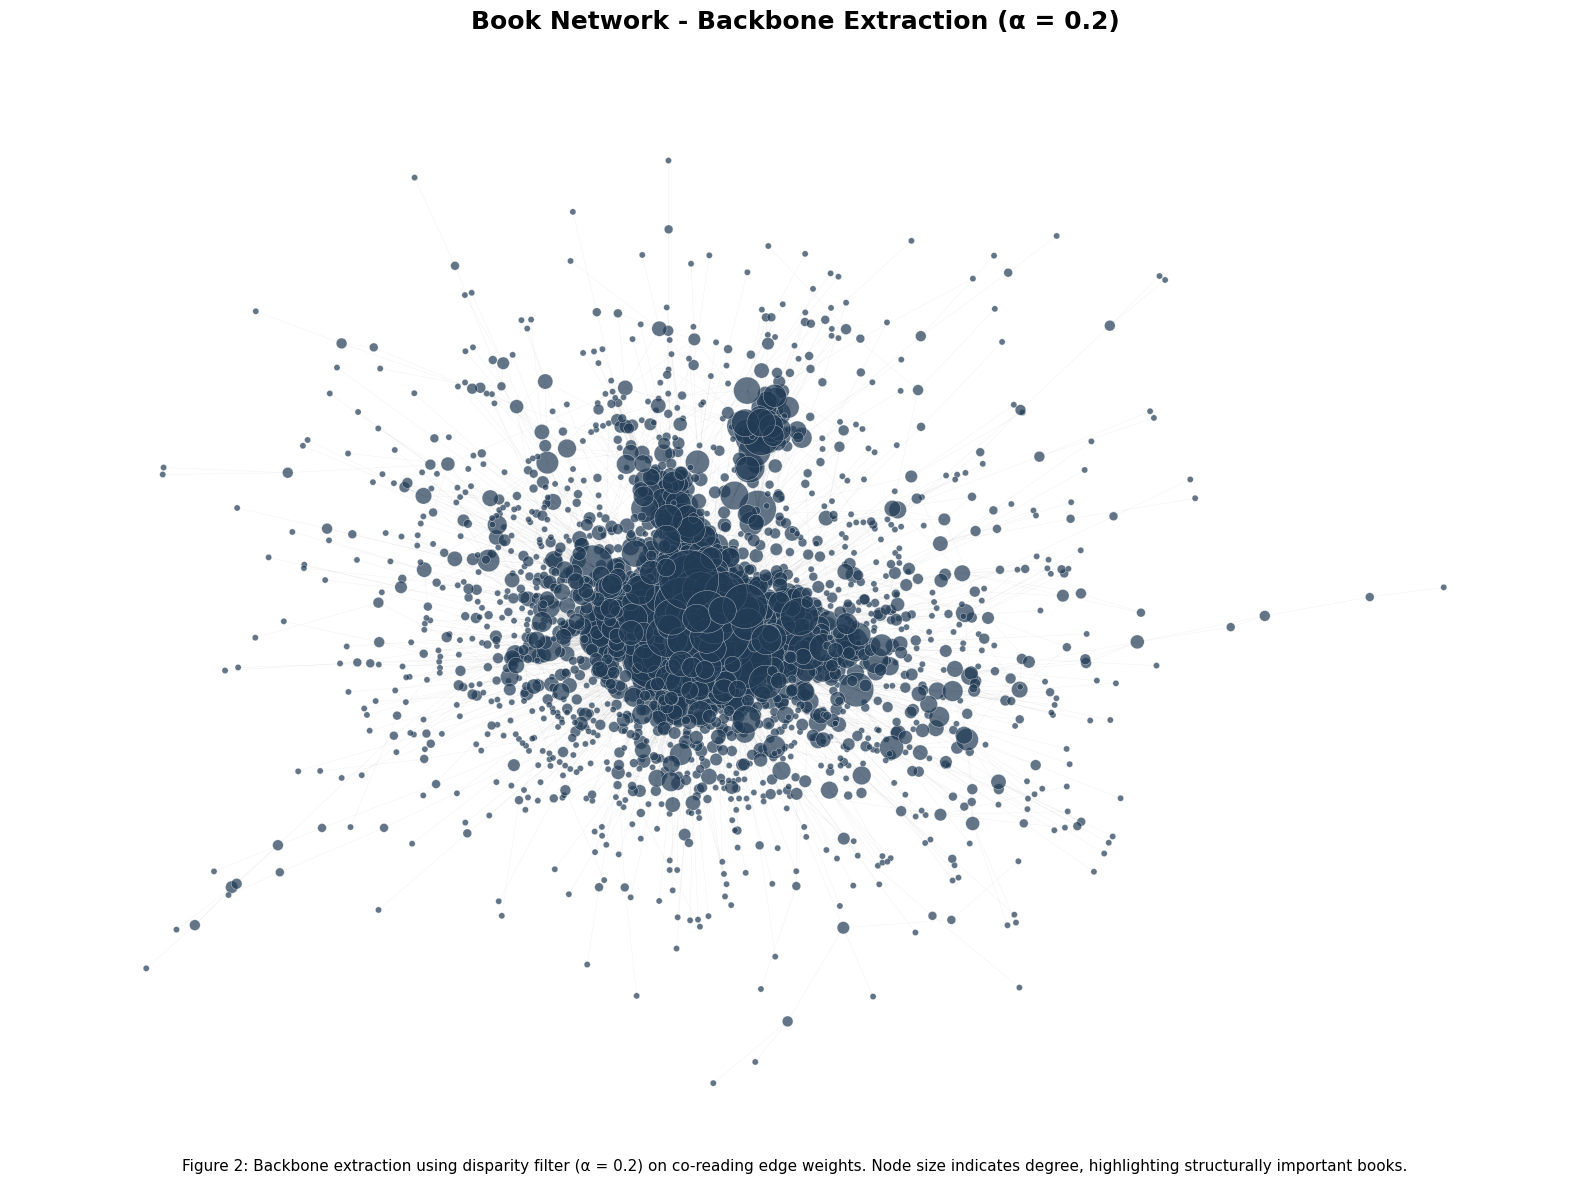

In [82]:
# 1. Use GCC with its existing weights (shared readers)
G = G_gcc  # nodes: books, edges: weighted by shared reviewers

print(f"Input graph (GCC): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 2. Disparity filter on existing 'weight'
alpha = 0.2

backbone = nx.Graph()
backbone.add_nodes_from(G.nodes(data=True))

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    k = len(neighbors)

    if k <= 1:
        for neighbor in neighbors:
            if not backbone.has_edge(node, neighbor):
                w = G[node][neighbor].get("weight", 1.0)
                backbone.add_edge(node, neighbor, weight=w)
        continue

    weights = [G[node][nbr].get("weight", 1.0) for nbr in neighbors]
    total_weight = sum(weights)

    for neighbor in neighbors:
        w = G[node][neighbor].get("weight", 1.0)
        p_ij = w / total_weight
        alpha_ij = (1 - p_ij) ** (k - 1)

        if alpha_ij < alpha:
            if not backbone.has_edge(node, neighbor):
                backbone.add_edge(node, neighbor, weight=w)

# 3. Clean backbone
backbone.remove_nodes_from(list(nx.isolates(backbone)))

if backbone.number_of_nodes() > 0:
    gcc_backbone_nodes = max(nx.connected_components(backbone), key=len)
    backbone = backbone.subgraph(gcc_backbone_nodes).copy()

print(f"Backbone: {backbone.number_of_nodes()} nodes, {backbone.number_of_edges()} edges")
print(f"Edges removed: {(1 - backbone.number_of_edges()/G.number_of_edges())*100:.1f}%")

# 4. Visualize
pos = nx.spring_layout(
    backbone,
    k=2 / np.sqrt(backbone.number_of_nodes()),
    iterations=50,
    seed=42,
    scale=10.0
)

degrees = dict(backbone.degree())
node_sizes = [degrees[node] * 20 for node in backbone.nodes()]

plt.figure(figsize=(16, 12), facecolor='white')
plt.title("Book Network - Backbone Extraction (α = 0.2)",
          fontsize=18, fontweight='bold', pad=25)

nx.draw_networkx_edges(
    backbone, pos,
    alpha=0.1,
    edge_color='dimgray',
    width=0.3
)

nx.draw_networkx_nodes(
    backbone, pos,
    node_size=node_sizes,
    node_color='#213b55',
    alpha=0.7,
    edgecolors='white',
    linewidths=0.3
)

plt.figtext(
    0.5, 0.02,
    "Figure 2: Backbone extraction using disparity filter (α = 0.2) on co-reading edge weights. "
    "Node size indicates degree, highlighting structurally important books.",
    wrap=True, ha="center", fontsize=11
)

plt.axis('off')
plt.tight_layout()
plt.show()

*Figure 2* shows the result of backbone extraction using $α=0.2$. With $α=0.2$, the disparity filter extracts a clean and meaningful backbone, preserving nearly all books but only the strongest co-reading links. The resulting backbone reveals the main routes through which readers move across the book network, while filtering out most of the weaker or incidental connections.

### 3.2 Centrality analysis

**Top books by degree centrality**

The degree centrality measures how many direct connections each book has within the book-book network. A high value indicates that a book shares reviews with many other books, making it a widely co-read title.

In [83]:
degree_centrality = nx.degree_centrality(backbone)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 books by degree centrality:")
for i, (node, centrality) in enumerate(top_degree, 1):
    print(f"{i}. {node}: {centrality:.4f}")

Top 5 books by degree centrality:
1. Jane Eyre (New Windmill): 0.0626
2. True Believer (Large Print): 0.0622
3. A Caress of Twilight (Meredith Gentry, Book 2): 0.0609
4. I Feel Bad About My Neck: And Other Thoughts on Being a Woman: 0.0597
5. America Alone: The End of the World as We Know It: 0.0539


These books are highly connected within the reading network because they are co-read with a large number of other titles. High degree centrality usually indicates that a book attracts readers with broad or varied reading habits. This pattern is often seen with widely known or classic works, which is reflected here by Jane Eyre and True Believer appearing among the most connected books in the network.

**Betweeness centrality**

Betweeness centrality measures how often a book lies on the shortest baths between other books. In a co-reading network, this highlights books that act as bridges between different reading communities. A standard approximation method that samples 500 source nodes is used due to exact betweenesss being very expensive to compute on the whole graph.

In [84]:
# Sample k nodes as sources
k = 500
sources = random.sample(list(backbone.nodes()), k)

betweenness_centrality = nx.betweenness_centrality_subset(
    backbone,
    sources=sources,
    targets=list(backbone.nodes()),
    normalized=True
)

top_betweenness = sorted(
    betweenness_centrality.items(),
    key=lambda x: x[1],
    reverse=True
)[:5]

print("Top 5 books by *approximate* betweenness centrality:")
for i, (node, centrality) in enumerate(top_betweenness, 1):
    print(f"{i}. {node}: {centrality:.4f}")


Top 5 books by *approximate* betweenness centrality:
1. Good to Great: 0.0180
2. Jane Eyre (New Windmill): 0.0168
3. America Alone: The End of the World as We Know It: 0.0152
4. I Feel Bad About My Neck: And Other Thoughts on Being a Woman: 0.0144
5. Treasure Island: 0.0128


These books sit on many cross-network paths, meaning they often connect different regions of the reading network. They are not necessarily the most popular or most co-read books, but they play an important role in linking communities.

**Eigenvector centrality**

Eigenvector centrality identifies books that are influential not because they connect to many other books, but because the connect to highly connected books. A book recieves a higher score if it shares readers with books that are themselves central in the network.

In [85]:
eigenvector_centrality = nx.eigenvector_centrality(backbone, max_iter=1000)
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 most central books by eigenvector centrality:")
for i, (node, centrality) in enumerate(top_eigenvector, 1):
    print(f"{i}. {node}: {centrality:.4f}")

Top 5 most central books by eigenvector centrality:
1. A Caress of Twilight (Meredith Gentry, Book 2): 0.1658
2. Dying to Please: 0.1434
3. A Hunger Like No Other (Immortals After Dark, Book 1): 0.1362
4. Second Sight (The Arcane Society, Book 1): 0.1352
5. Memory in Death (In Death #22): 0.1349


The ouput shows a list of books with highly influential positions in the reading network. These titles are not necessarily the most popular, but they share readership with books that are themselves highly connected.

## ***4. Community detection***

**Louvain Algorithm**

To uncover the large-scale structure of the reading network, the Louvain algorithm is applied. The algorithm groups nodes into communities based on how densely they connect to each other. Louvain also optimizes the *modularity* ***$Q$***, a measure of how strongly the network divides into well-defined clusters. A higher modularity indicates clearer, more meaningful community structure.

In [86]:
G_comm = G_gcc

# Louvain community detection
partition = community_louvain.best_partition(
    G_comm,
    weight="weight",      # use co-reading weight
    resolution=1.0,
    random_state=42
)

# partition is a dict: node -> community_id (0,1,2,...)
num_comms = len(set(partition.values()))
print(f"Detected {num_comms} communities")

mod = community_louvain.modularity(partition, G_comm, weight="weight")
print(f"\nModularity Q: {mod:.3f}")


Detected 17 communities

Modularity Q: 0.540


From the output above, Louvain detected 17 with a modularity $Q = 0.540$. This a strong score, indicating that the communities are internally cohesive and well separated from each other. This means that readers tend to move within distinct groups of books. Note

C:\Users\Malin Haugland Høli\AppData\Local\Temp\ipykernel_23576\746854489.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = get_cmap("tab20", K_eff)


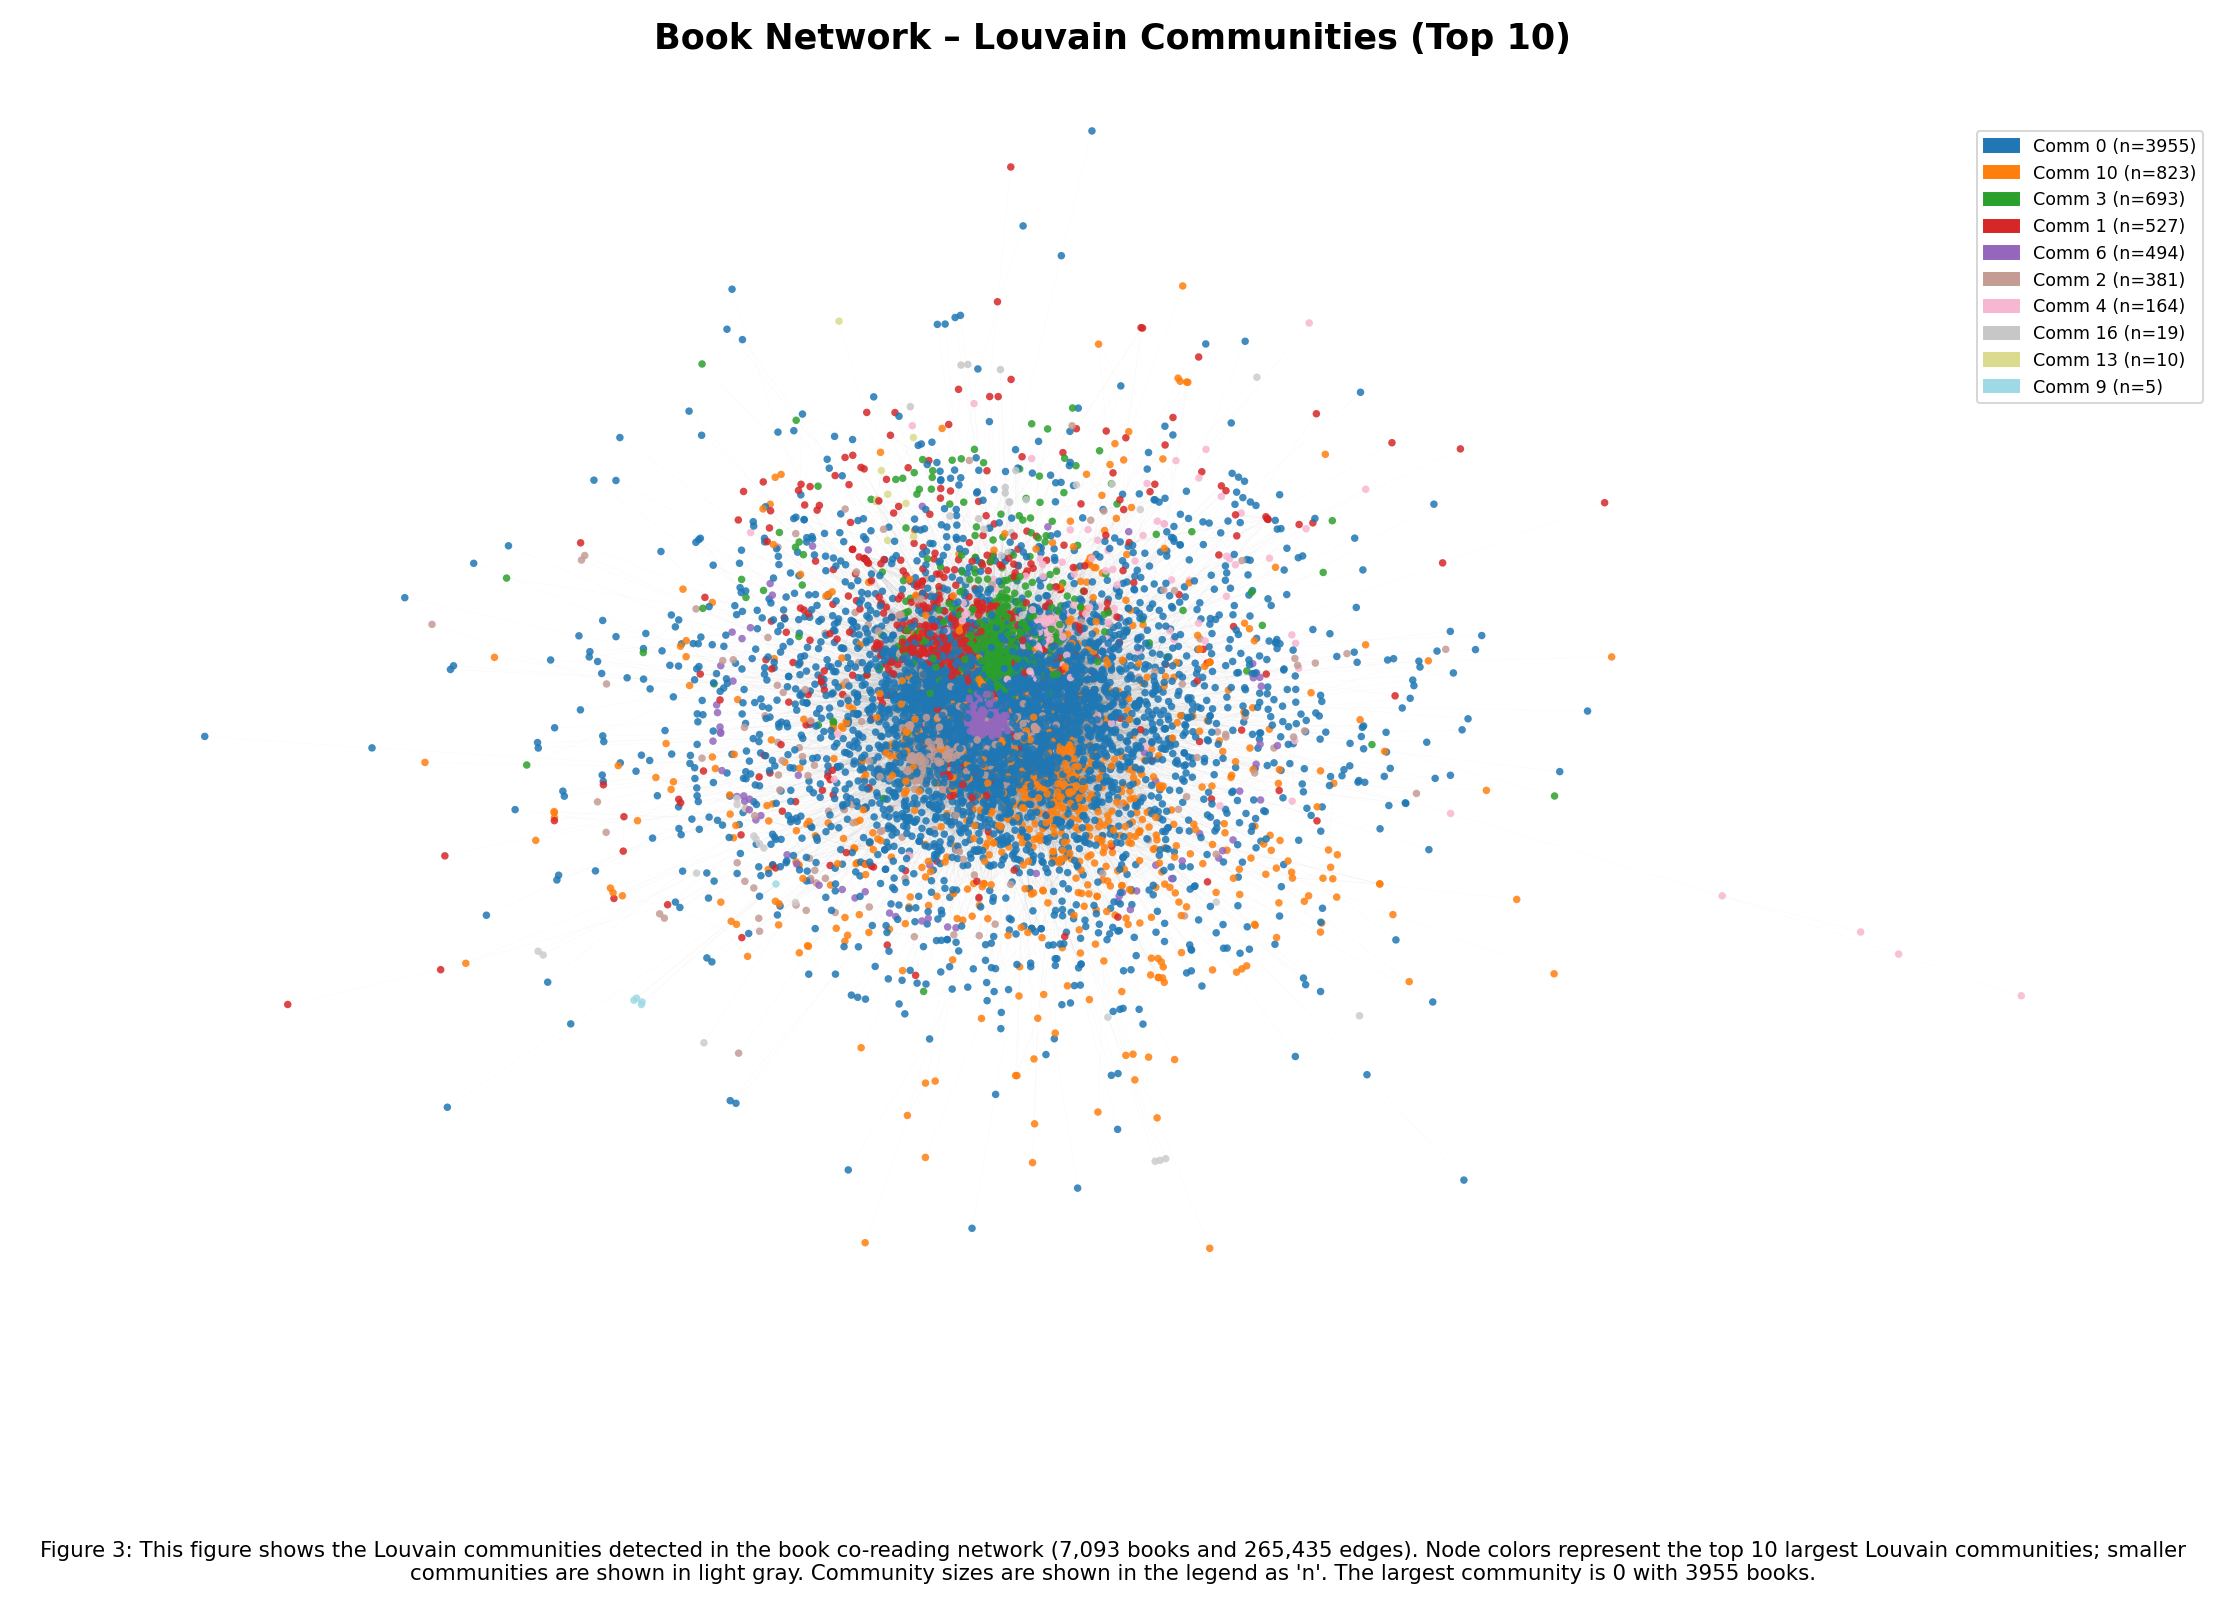

In [87]:
import math
from collections import Counter
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap

# --- Layout ---
pos = nx.spring_layout(
    G_comm,
    k=2 / np.sqrt(G_comm.number_of_nodes()),
    iterations=50,
    seed=42,
    scale=10.0
)

# --- Community counts ---
counts = Counter(partition[n] for n in G_comm.nodes())

# How many of the largest communities to color?
K = 10
largest = [cid for cid, _ in counts.most_common(K)]
K_eff = len(largest)

# --- Build color map for top K communities ---
palette = get_cmap("tab20", K_eff)
color_map = {cid: palette(i) for i, cid in enumerate(largest)}

# Color for "other" smaller communities
OTHER_COLOR = (0.8, 0.8, 0.8, 0.4)

# Node colors
node_colors = [color_map.get(partition[n], OTHER_COLOR) for n in G_comm.nodes()]

fig, ax = plt.subplots(figsize=(16, 12), dpi=140)
nx.draw_networkx_edges(
    G_comm, pos,
    alpha=0.05,
    edge_color="dimgray",
    width=0.2,
    ax=ax
)

nx.draw_networkx_nodes(
    G_comm, pos,
    node_size=15,
    node_color=node_colors,
    linewidths=0,
    alpha=0.85,
    ax=ax
)

ax.set_axis_off()

fig.suptitle(
    f"Book Network – Louvain Communities (Top {K_eff})",
    fontsize=18, fontweight="bold", y=0.95
)

caption_text = (
    f"Figure 3: This figure shows the Louvain communities detected in the book co-reading network "
    f"({G_comm.number_of_nodes():,} books and {G_comm.number_of_edges():,} edges). "
    f"Node colors represent the top {K_eff} largest Louvain communities; smaller communities "
    f"are shown in light gray. Community sizes are shown in the legend as 'n'. "
    f"The largest community is {largest[0]} with {counts[largest[0]]} books."
)

fig.text(
    0.5, 0.02, caption_text,
    fontsize=11, ha="center", va="bottom", wrap=True,
    transform=fig.transFigure
)

handles = [
    mpatches.Patch(
        color=color_map[cid],
        label=f"Comm {cid} (n={counts[cid]})"
    )
    for cid in largest
]

ax.legend(
    handles=handles,
    loc="upper right",
    fontsize=9,
    frameon=True,
    bbox_to_anchor=(1, 0.92)
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


*Figure 3* shows that the center of the graph is heavily dominated by one large community. This happens because many books share readers broadly and co-reading patterns create a massive central cluster. It probably includes classics, bestsellers and books with broad appeal. Even though Louvain found in total 17 communities (top 10 illustrated above), all the nodes remain in one large blob. This indicates that readers do not stick strictly to one genre or one topic.

**Top 3 books in the biggest communities**



In [88]:
comm_df = pd.DataFrame({
    "Title": list(partition.keys()),
    "community": list(partition.values())
})

community_sizes = comm_df["community"].value_counts().sort_values(ascending=False)
largest_communities = community_sizes.index[:3]

genre_map = (
    books_df[["Title", "categories"]]
    .drop_duplicates(subset=["Title"])
    .set_index("Title")["categories"]
    .to_dict()
)

# --- Rank books inside each community by degree ---
degree_dict = dict(G_comm.degree())

print("\nTop 3 books in the three largest communities:\n")

for comm in largest_communities:
    print(f"Community {comm} (size {community_sizes[comm]}):")

    # Books in this community
    books_in_comm = comm_df[comm_df["community"] == comm]["Title"]

    # Sort by degree (descending)
    top_books = sorted(
        books_in_comm,
        key=lambda x: degree_dict.get(x, 0),
        reverse=True
    )[:3]

    for i, book in enumerate(top_books, 1):
        genre = genre_map.get(book, "Unknown")
        deg = degree_dict.get(book, 0)
        print(f"  {i}. {book}  | Genre: {genre} | Degree: {deg}")

    print()



Top 3 books in the three largest communities:

Community 0 (size 3955):
  1. America Alone: The End of the World as We Know It  | Genre: Political Science | Degree: 1042
  2. I Feel Bad About My Neck: And Other Thoughts on Being a Woman  | Genre: Humor | Degree: 1024
  3. Jane Eyre (New Windmill)  | Genre: Charity-schools | Degree: 1013

Community 10 (size 823):
  1. Blue Like Jazz: Nonreligious Thoughts on Christian Spirituality  | Genre: Biography & Autobiography | Degree: 320
  2. How To Cook Everything: Simple Recipes for Great Food  | Genre: Cooking | Degree: 195
  3. The Case Against Hillary Clinton  | Genre: Political Science | Degree: 159

Community 3 (size 693):
  1. True Believer (Large Print)  | Genre: Fiction | Degree: 1040
  2. 1632 (The Assiti Shards)  | Genre: Fiction | Degree: 977
  3. Nights In Rodanthe (Turtleback School & Library Binding Edition)  | Genre: Fiction | Degree: 961



The top books in the largest community come from very different genres, and suggests that community 0 represents a broad, highly interconnected core of the network. In contrast, the third largest commmunity is dominated entirely by fiction titles. This community appears to capture a fiction-heavy reading audience.

**Genre-based partition**

Does the network organize around genres?

In [89]:
# Collapse to one row per book, keeping the first category
book_genres = (
    books_df[["Title", "categories"]]
    .dropna(subset=["categories"])
    .drop_duplicates(subset=["Title"])
    .set_index("Title")["categories"]
)

# Convert to dict: Title -> category
genre_map = book_genres.to_dict()


# For every node (book) in the graph, assign its category (or "Unknown")
genre_partition = {
    node: genre_map.get(node, "Unknown")
    for node in G_gcc.nodes()
}

genre_modularity = community_louvain.modularity(
    genre_partition,
    G_gcc,
    weight="weight"  # if edges have 'weight'; omit if unweighted
)

print("Genre-based modularity:", genre_modularity)


Genre-based modularity: 0.14759389240293624


The modularity $Q = 0.147$ from the output above is significantly lower than the one produced by the Louvain algorithm. This indicates that the co-reading network does not organize strongly around the genre labels in the dataset. Genre alone does not explain how people move across books.

## ***5. Sentiment analysis***

### 5.1 Classifying reviews as negative or positive

A transformer model is used to classify the content in the *text/review* column as either positive or negative. Because the full dataset contains over 120 000 reviews, which is too computationally expensive to process on CPU, the analysis focuses on the top 1000 most central books in the network, using up to five reviews per book.

In [90]:
# 1) Rank books by degree in the GCC
deg = dict(G_gcc.degree())
K = 1000

top_books = sorted(deg, key=deg.get, reverse=True)[:K]
top_books_set = set(top_books)

print(f"Total books in GCC: {G_gcc.number_of_nodes():,}")
print(f"Top-K books selected: {len(top_books_set):,}")

N_PER_BOOK = 5   # max reviews per book

df_top = (
    books_df[books_df["Title"].isin(top_books_set)]
    .sort_values("review/time")      # or .sample(frac=1, random_state=42)
    .groupby("Title")
    .head(N_PER_BOOK)
    .copy()
)

texts = df_top["review/text"].fillna("").tolist()

print(f"Reviews in this subset: {len(texts):,}")

Total books in GCC: 7,093
Top-K books selected: 1,000
Reviews in this subset: 4,629


In [ ]:
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1   # CPU
)

BATCH_SIZE = 32
MAX_LEN = 128

results = []
for i in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch = texts[i:i + BATCH_SIZE]
    out = sentiment_pipe(
        batch,
        truncation=True,
        max_length=MAX_LEN,
        batch_size=BATCH_SIZE
    )
    results.extend(out)


Device set to use cpu
100%|██████████| 145/145 [08:50<00:00,  3.66s/it]


**Positive and negative reviews**

In [92]:
df_top["sentiment_label"] = [r["label"] for r in results]
df_top["sentiment_score"] = [r["score"] for r in results]

pos_count = (df_top["sentiment_label"] == "POSITIVE").sum()
neg_count = (df_top["sentiment_label"] == "NEGATIVE").sum()
total = len(df_top)

print(f"Total POSITIVE reviews: {pos_count} ({pos_count / total:.2%})")
print(f"Total NEGATIVE reviews: {neg_count} ({neg_count / total:.2%})")

Total POSITIVE reviews: 3577 (77.27%)
Total NEGATIVE reviews: 1052 (22.73%)


In [93]:
top_pos = df_top.nlargest(3, "sentiment_score")

for i, row in top_pos.iterrows():
    print("=" * 90)
    print(f"TOP POSITIVE #{list(top_pos.index).index(i)+1}")
    print(f"Book: {row['Title']}")
    print(f"Sentiment Score: {row['sentiment_score']:.3f}")
    print("Review:")
    print(row["review/text"])
    print()

TOP POSITIVE #1
Book: All About Passion
Sentiment Score: 1.000
Review:
I read this book in one day; I was so thrilled that the author finally wrote a story worthy of Devil's Bride. It is fun and sexy and a great read. Please give us more like this!

TOP POSITIVE #2
Book: Hailstones and Halibut Bones (Adventures in Color)
Sentiment Score: 1.000
Review:
This is an excellent book, Great artwork and the poetry sings with all the magic of God's creation, a great book for all ages.

TOP POSITIVE #3
Book: Wait Until Midnight
Sentiment Score: 1.000
Review:
Another enjoyable read with fun and charming characters and all manner of twists and turns. Highly recommend.



In [94]:
top_neg = df_top.nsmallest(3, "sentiment_score")

for i, row in top_neg.iterrows():
    print("=" * 90)
    print(f"TOP NEGATIVE #{list(top_neg.index).index(i)+1}")
    print(f"Book: {row['Title']}")
    print(f"Sentiment Score: {row['sentiment_score']:.3f}")
    print("Review:")
    print(row["review/text"])
    print()

TOP NEGATIVE #1
Book: Rockbound
Sentiment Score: 0.500
Review:
I wanted to read this book just because of the positive word of mouth the book gets and I believed it would be interesting. What I was not prepared for was the difficult slang that the author used through most of the book. Ok so it makes the book authentic, but I found my self getting frustrated at times and I do not read a book to get frustrated. The book is about a fishing family in what must be one of the worst weather locations on the planet. Cold, wet, and dark, no wonder the folks there were in such a perpetual bad mood.I must say that the book has a way to suck you into the story. There is so much nasty under current that I kept reading just to find out the next tough stretch. I also loved all the detail of the fishing industry in the early 1900's. It is fitting that such a difficult profession was the occupation of this group of islanders. Overall I did enjoy the book. It had a ton of historic detail and great chara

The most positive and negative reviews reveal that strong emotional reactions, both enthusiastic and conflicted, shape how readers describe books. Positive reviews focus on enjoyment, engaging characters, and satisfying stories, while the “negative” reviews are more mixed, often describing specific frustrations (such as writing style or plot choices). Even the lowest sentiment scores remain relatively high, suggesting that readers tend to express balanced or nuanced criticism rather than pure negativity.

### 5.2 Classifying books as "happy" or "sad"

The below code tries to classify the books in the reading network, focusing on the top 1000 most central books in the giant connected component (based on degree). Using a transformer-based emotion classifier, each book is assigned a joy score, sadness score, and an overall emotion label (happy, sad, or mixed/neutral).

In [95]:
model_name = "j-hartmann/emotion-english-distilroberta-base"

emotion_pipe = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=model_name,
    device=-1,
    top_k=None
)

Device set to use cpu


In [ ]:
# 0) Base metadata: one row per book
books_meta = (
    books_df[["Title", "description", "categories"]]
    .drop_duplicates(subset="Title")
    .reset_index(drop=True)
)

# 1) Top-K books in GCC
deg = dict(G_gcc.degree())
K = 1000
top_books = sorted(deg, key=deg.get, reverse=True)[:K]
top_books_set = set(top_books)

meta_top = (
    books_meta[books_meta["Title"].isin(top_books_set)]
    .drop_duplicates("Title")
    .copy()
)

descs = meta_top["description"].fillna("").tolist()
print(f"Descriptions for top-K books: {len(descs):,}")

# 2) Run emotion model on these descriptions
BATCH_SIZE = 32
MAX_LEN = 128

emotion_results = []
for i in tqdm(range(0, len(descs), BATCH_SIZE)):
    batch = descs[i:i + BATCH_SIZE]
    out = emotion_pipe(
        batch,
        truncation=True,
        max_length=MAX_LEN
    )
    emotion_results.extend(out)

# 3) Convert model output to joy/sad/labels
joy_scores = []
sad_scores = []
emotion_labels = []

for scores in emotion_results:
    # scores is a list of dicts: [{'label': 'joy', 'score': ...}, ...]
    d = {s["label"]: s["score"] for s in scores}

    joy = d.get("joy", 0.0)
    sad = d.get("sadness", 0.0)

    joy_scores.append(joy)
    sad_scores.append(sad)

    if joy - sad > 0.15:
        emotion_labels.append("happy")
    elif sad - joy > 0.15:
        emotion_labels.append("sad")
    else:
        emotion_labels.append("mixed/neutral")

meta_top["joy_score"] = joy_scores
meta_top["sad_score"] = sad_scores
meta_top["emotion_label"] = emotion_labels

# 4) Merge back into books_meta
books_meta = books_meta.merge(
    meta_top[["Title", "joy_score", "sad_score", "emotion_label"]],
    on="Title",
    how="left"
)

Descriptions for top-K books: 1,000


100%|██████████| 32/32 [01:36<00:00,  3.00s/it]


In [97]:
labels = books_meta["emotion_label"].dropna()

# Count each label
counts = labels.value_counts()

happy = counts.get("happy", 0)
sad = counts.get("sad", 0)
neutral = counts.get("mixed/neutral", 0)

total = happy + sad + neutral

print("Emotion counts (top-K books with emotion scores):")
print(f"Happy books:   {happy}")
print(f"Sad books:     {sad}")
print(f"Neutral books: {neutral}")
print(f"Total labeled: {total}")

if total > 0:
    print("\nPercentages:")
    print(f"Happy:   {happy / total:.1%}")
    print(f"Sad:     {sad / total:.1%}")
    print(f"Neutral: {neutral / total:.1%}")


examples = {}

for label in ["happy", "sad", "mixed/neutral"]:
    row = books_meta.loc[
        books_meta["emotion_label"] == label,
        ["Title", "description", "joy_score", "sad_score", "emotion_label"]
    ].head(3)

    examples[label] = row

# Display them together
for label, row in examples.items():
    print(f"\n=== Example {label.upper()} book ===")
    display(row)


Emotion counts (top-K books with emotion scores):
Happy books:   205
Sad books:     117
Neutral books: 678
Total labeled: 1000

Percentages:
Happy:   20.5%
Sad:     11.7%
Neutral: 67.8%

=== Example HAPPY book ===


,Title,description,joy_score,sad_score,emotion_label
133,The Language of Mathematics: Making the Invisi...,Taking the reader on a wondrous journey throug...,0.265677,0.002828,happy
150,Sisterchicks on the Loose! (Sisterchicks Serie...,Women friends in Finland love each other like ...,0.296926,0.032615,happy
200,Rhiana,This book describes the life and career of Rih...,0.456989,0.015619,happy



=== Example SAD book ===


,Title,description,joy_score,sad_score,emotion_label
13,Heartwood: Trickster's Game #1,"Year after year, season after season, for as l...",0.022007,0.204433,sad
106,Eyeshot (Wesleyan Poetry Series),Scintillating new work from a celebrated conte...,0.028824,0.338869,sad
128,Rainbow's End,Traces the author's coming-of-age in civil-war...,0.002081,0.335216,sad



=== Example MIXED/NEUTRAL book ===


,Title,description,joy_score,sad_score,emotion_label
10,Dead Sexy,In The Still Of The Night The city is in a pan...,0.001840,0.010371,mixed/neutral
35,Junk Science Judo: Self-Defense against Health...,"This book is a simple, easy-to-read guide to d...",0.009702,0.015357,mixed/neutral
37,Bette (Women of Ivy Manor Series #2),Award-winning author Lyn Cote continues her se...,0.072914,0.007095,mixed/neutral


The output above shows that most titles fall into the neutral/mixed category, indicating that many descriptions contain little explicit emotional language. Because this analysis focuses specifically on high-degree books, the results suggest that the most widely co-read titles tend to have emotionally neutral descriptions.

In [ ]:
i = 25  # choose any index
print("DESCRIPTION:")
print(books_meta['description'].iloc[i])
print("\nPREDICTED EMOTION SCORES:")
print(emotion_results[i])


DESCRIPTION:
When the death of a relative, a friend, or a pet happens or is about to happen . . . how can we help a child to understand? Lifetimes is a moving book for children of all ages, even parents too. It lets us explain life and death in a sensitive, caring, beautiful way. Lifetimes tells us about beginnings. And about endings. And about living in between. With large, wonderful illustrations, it tells about plants. About animals. About people. It tells that dying is as much a part of living as being born. It helps us to remember. It helps us to understand. Lifetimes . . . a very special, very important book for you and your child. The book that explains—beautifully—that all living things have their own special Lifetimes.

PREDICTED EMOTION SCORES:
[{'label': 'joy', 'score': 0.7334994673728943}, {'label': 'neutral', 'score': 0.16302435100078583}, {'label': 'sadness', 'score': 0.045269615948200226}, {'label': 'disgust', 'score': 0.02863088995218277}, {'label': 'surprise', 'score':

**Emotion profile in Louvain communities**

The code below allows us to examine whether structurally distinct groups of readers (identified by Louvain clustering) also differ in the emotional tone of the books they read.

C:\Users\Malin Haugland Høli\AppData\Local\Temp\ipykernel_23576\2553133134.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(grouped.index))


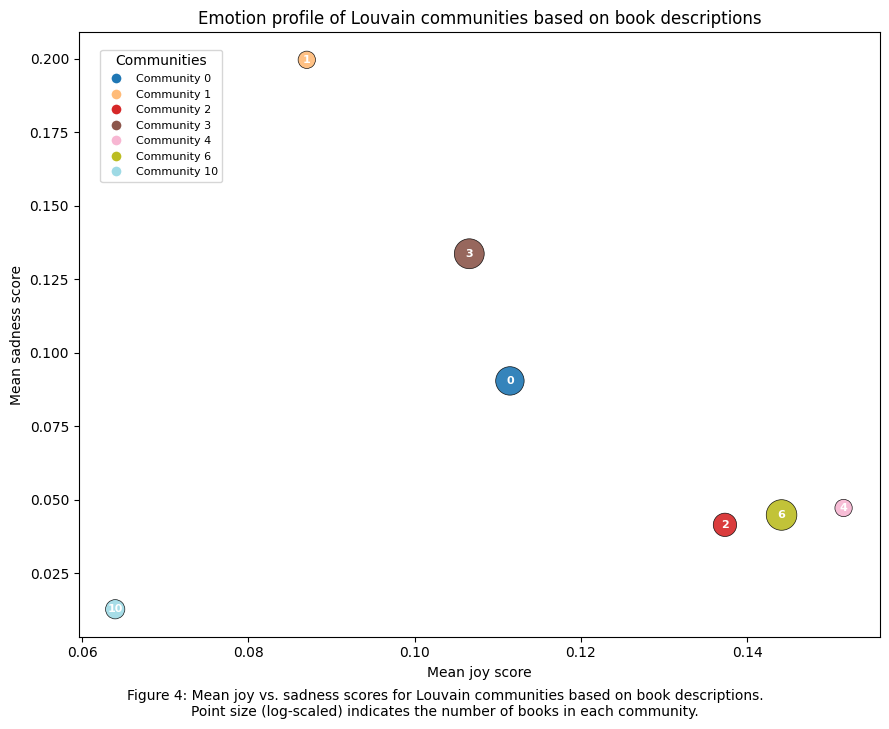

In [101]:
comm_df = pd.DataFrame({
    "Title": list(partition.keys()),
    "community": list(partition.values())
})


# 2) Merge communities into books_meta
books_meta = books_meta.merge(comm_df, on="Title", how="left")

# Group by community
grouped = (
    books_meta
    .dropna(subset=["joy_score", "sad_score", "community"])
    .groupby("community")
    .agg(
        mean_joy=("joy_score", "mean"),
        mean_sad=("sad_score", "mean"),
        n_books=("Title", "count")
    )
)

# Ensure clean integer community IDs
grouped.index = grouped.index.astype(int)

# Create a fresh color map only for plotted communities
cmap = plt.cm.get_cmap("tab20", len(grouped.index))
colors = {cid: cmap(i) for i, cid in enumerate(grouped.index)}
color_array = [colors[cid] for cid in grouped.index]

# --- log-scaled point sizes ---
sizes = np.log1p(grouped["n_books"]) * 80  # tweak 80 up/down if needed

plt.figure(figsize=(9, 7))

sc = plt.scatter(
    grouped["mean_joy"],
    grouped["mean_sad"],
    s=sizes,
    c=color_array,
    alpha=0.90,
    edgecolors="black",
    linewidth=0.5
)

# Label points
for cid, row in grouped.iterrows():
    plt.text(
        row["mean_joy"],
        row["mean_sad"],
        str(cid),
        fontsize=8,
        weight="bold",
        ha="center",
        va="center",
        color="white"
    )

plt.xlabel("Mean joy score")
plt.ylabel("Mean sadness score")
plt.title("Emotion profile of Louvain communities based on book descriptions")

# Legend only for plotted communities
handles = [
    plt.Line2D(
        [0], [0],
        marker="o",
        color="w",
        label=f"Community {cid}",
        markerfacecolor=colors[cid],
        markersize=8
    )
    for cid in grouped.index
]

plt.legend(
    handles=handles,
    title="Communities",
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),
    framealpha=0.8,
    fontsize=8
)

plt.figtext(
    0.5, -0.03,
    "Figure 4: Mean joy vs. sadness scores for Louvain communities based on book descriptions.\n"
    "Point size (log-scaled) indicates the number of books in each community.",
    ha="center",
    fontsize=10
)

plt.tight_layout()
plt.show()


The scatter plot in *Figure 4* shows how the largest Louvain communities differ emotionally based on the book descriptions of the books they contain. The x-axis reflects how “joyful” the descriptions are on average, while the y-axis reflects “sadness.” The size of each point represents the number of books in that community (log-scaled).

### 5.3 Term Frequency-Inverse Document Frequency (TF-IDF)

To better understand what characterizes the three largest Louvain communities, *TF-IDF* was used to extract the most distinctive terms from the reviews of a representative book from each community.

In [102]:
books_in_network = set(G_gcc.nodes())

df_net = (
    books_df[books_df["Title"].isin(books_in_network)]
    .copy()
)

# Concatenate all reviews for each book into a single text
book_texts = (
    df_net
    .groupby("Title")["review/text"]
    .apply(lambda s: " ".join(s.dropna().astype(str)))
    .reset_index()
    .rename(columns={"review/text": "text"})
)

book_texts.head()


,Title,text
0,"""Come to Me""",This book absolutely stunned me. I started rea...
1,"""Forget Not Love"": The Passion of Maximilian K...","If you want to know what it means to ""Love"" as..."
2,"""Happiness Is Not My Companion"": The Life of G...","""Happiness Is Not My Companion"" The Life of Go..."
3,"""Life Was Never Meant to Be a Struggle""",All of Stuart Wilde's books are excellent. Thi...
4,"""Mom, Dad . . . I'm Pregnant"": When Your Daugh...",The whole day is fuzzy in my memory. The conve...


**Top words in reviews per book**

By extracting the most distinctive terms from reviews of selected books, the resulting word-clouds reveal the themes and ideas that readers discuss most prominently for each book.

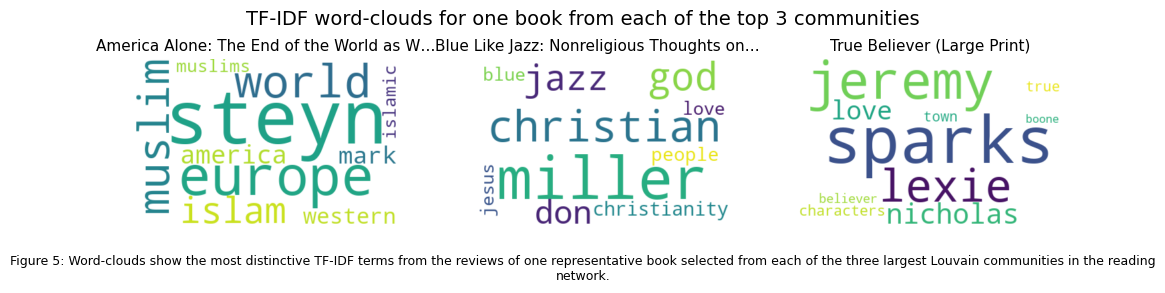

In [103]:
# ----------------------------------------------------
# 1) Identify the top 3 largest Louvain communities
# ----------------------------------------------------
community_sizes = Counter(partition.values())
top3_communities = [cid for cid, _ in community_sizes.most_common(3)]

# Precompute degree for all books
degree_dict = dict(G_gcc.degree())

# Pick the top (highest-degree) book from each community
sample_titles = []
for cid in top3_communities:
    # all books in this community
    books_in_comm = [title for title, c in partition.items() if c == cid]

    # pick the one with highest degree
    top_book = max(books_in_comm, key=lambda x: degree_dict.get(x, 0))
    sample_titles.append(top_book)

# ----------------------------------------------------
# 2) Aggregate reviews per selected book
# ----------------------------------------------------
df_subset = (
    books_df[books_df["Title"].isin(sample_titles)]
    .groupby("Title")["review/text"]
    .apply(lambda s: " ".join(s.dropna().astype(str).str.lower()))
    .to_dict()
)

# ----------------------------------------------------
# 3) TF–IDF vectorization
# ----------------------------------------------------
extra_stops = {
    "book", "books", "read", "reading", "story", "stories",
    "author", "writers", "write", "written", "page", "pages",
    "chapter", "chapters", "novel", "one", "two", "three",
    "time", "really", "like", "just", "good", "great", "well",
    "also", "even", "still", "thinks", "think", "would", "could",
    "make", "appears", "appear", "particularly"
}
my_stop_words = list(ENGLISH_STOP_WORDS.union(extra_stops))

vectorizer = TfidfVectorizer(
    stop_words=my_stop_words,
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",
    min_df=1,
    max_features=4000
)

X = vectorizer.fit_transform(df_subset.values())
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(
    X.toarray(),
    index=df_subset.keys(),
    columns=feature_names
)

# ----------------------------------------------------
# 4) Extract top 10 words per book
# ----------------------------------------------------
top_words_per_book = {}
for title in tfidf_df.index:
    top_words = tfidf_df.loc[title].sort_values(ascending=False).head(10)
    top_words_per_book[title] = top_words

# ----------------------------------------------------
# 5) Plot word clouds (3 books)
# ----------------------------------------------------
n_books = len(top_words_per_book)
n_cols = 3
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()

for i, (title, top_words) in enumerate(top_words_per_book.items()):
    freq_dict = {word: max(val, 1e-6) for word, val in top_words.items()}
    wc = WordCloud(
        width=400,
        height=250,
        background_color="white",
        colormap="viridis"
    )
    wc.generate_from_frequencies(freq_dict)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    short_title = (title[:40] + "…") if len(title) > 40 else title
    axes[i].set_title(short_title, fontsize=11)

fig.suptitle(
    "TF-IDF word-clouds for one book from each of the top 3 communities",
    fontsize=14,
    y=0.92
)

fig.text(
    0.5, 0.01,
    "Figure 5: Word-clouds show the most distinctive TF-IDF terms from the reviews of one representative "
    "book selected from each of the three largest Louvain communities in the reading network.",
    ha='center', va='bottom', fontsize=9, wrap=True
)

plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.08, top=0.88)
plt.show()


*Figure 5* reveals that reviewers across communities discuss very different kinds of content, such as political arguments, spiritual reflections and romantic storyteling.

**Top words in reviews per community**

To better understand the differences between reviews in the largest reading communities detected by the Louvain algorithm, this section examines content of reviews associated with the most central book in each of the three communities.

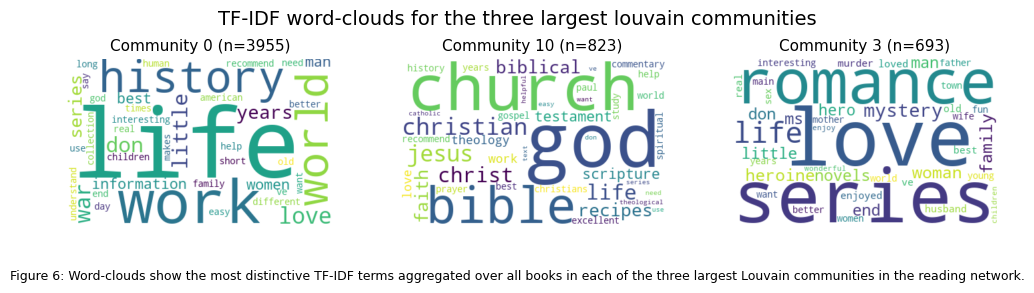

In [106]:
extra_stops = {
    "book", "books", "story", "stories", "author", "characters",
    "novel", "read", "reading", "page", "pages", "chapter", "chapters",
    "time", "really", "like", "just", "good", "great", "well", "also",
    "even", "still", "would", "could", "think", "thinks", "make",
    "made", "people", "character", "plot", "review", "reviews",
    "one", "two", "three", "first", "last", "new", "way", "lot",
    "did", "didn", "does", "doesn", "thing", "things", "quot", "know",
    "thought", "reader", "written", "writing"
}

my_stop_words = list(ENGLISH_STOP_WORDS.union(extra_stops))

vectorizer = TfidfVectorizer(
    max_df=0.8,           # ignore very common words
    min_df=5,             # ignore very rare words
    max_features=10000,   # cap vocabulary size
    stop_words=my_stop_words  # remove English stopwords
)

X_all = vectorizer.fit_transform(book_texts["text"])
feature_names_all = vectorizer.get_feature_names_out()

# Map Title -> community from Louvain partition
book_texts["community"] = book_texts["Title"].map(partition)

# Identify the 3 largest communities
comm_counts = Counter(book_texts["community"])
largest_comms = [cid for cid, _ in comm_counts.most_common(3)]

# Prepare data: mean TF–IDF vectors for top 3 communities
community_word_scores = {}  # cid -> {word: score}

for cid in largest_comms:
    mask = (book_texts["community"] == cid).values  # boolean array
    X_comm = X_all[mask]                            # TF–IDF rows for this community

    # Mean TF–IDF over all books in the community
    mean_tfidf = X_comm.mean(axis=0)
    mean_arr = np.asarray(mean_tfidf).ravel()

    top_idx = mean_arr.argsort()[::-1][:40]  # take top 40 terms for nicer clouds
    words = [feature_names_all[i] for i in top_idx]
    scores = [float(mean_arr[i]) for i in top_idx]

    community_word_scores[cid] = dict(zip(words, scores))

# ---- Plot word clouds for the 3 largest communities ----
n_comms = len(largest_comms)
n_cols = 3
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for ax, cid in zip(axes, largest_comms):
    freq_dict = community_word_scores[cid]
    wc = WordCloud(
        width=400,
        height=250,
        background_color="white",
        colormap="viridis"
    )
    wc.generate_from_frequencies(freq_dict)

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Community {cid} (n={comm_counts[cid]})", fontsize=11)

fig.suptitle(
    "TF-IDF word-clouds for the three largest louvain communities",
    fontsize=14,
    y=0.92
)

fig.text(
    0.5, 0.01,
    "Figure 6: Word-clouds show the most distinctive TF-IDF terms aggregated over all books in each of the "
    "three largest Louvain communities in the reading network.",
    ha='center', va='bottom', fontsize=9, wrap=True
)

plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.08, top=0.88)
plt.show()


The world clouds in *Figure 6* reveal the dominant themes discussed in reviews from the three largest Louvain communities. Community 5 centers on life-writing, personal experiences and historical topics. Community 8 is strongly shaped by biblical themes, and community 3 is characterized by romance, relationships and series-based fiction.

## ***6. Answering research questions***

### 6.1 Do most people read "happy" books?

In [104]:
mood_map = (
    books_meta
    .dropna(subset=['emotion_label'])
    .set_index('Title')['emotion_label']
    .to_dict()
)

# 2) Build attribute dict for *nodes in book_graph*
mood_attr = {book: mood_map.get(book, 'unknown') for book in book_graph.nodes()}

# 3) Attach to book_graph
nx.set_node_attributes(book_graph, mood_attr, 'book_mood')


In [105]:
# Largest connected component in the book-book network with emotion labels
largest_cc = max(nx.connected_components(book_graph), key=len)
H = book_graph.subgraph(largest_cc).copy()

mood_colors = {
    'happy': 'tab:green',
    'sad': 'tab:red',
    'mixed/neutral': 'tab:orange',
    'unknown': 'tab:gray'
}

node_colors = [
    mood_colors.get(H.nodes[n].get('book_mood', 'unknown'), 'tab:gray')
    for n in H.nodes()
]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H, k=0.15, seed=42)

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=10, alpha=0.9)
nx.draw_networkx_edges(H, pos, width=0.1, alpha=0.3)
plt.axis('off')
plt.title("Largest component of book network colored by mood", fontsize=12)
plt.show()


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# --- Mood Distribution in Largest Component ---
print("=== Mood Distribution in Largest Component (proportion of books) ===")
moods = nx.get_node_attributes(H, 'book_mood')
mood_distribution = pd.Series(list(moods.values())).value_counts(normalize=True)
print(mood_distribution)
print("\n")


# --- Average Degree (Centrality) by Mood ---
print("=== Average Degree of Books by Mood (network centrality indicator) ===")
deg = dict(H.degree())

df_deg = pd.DataFrame({
    "Title": list(deg.keys()),
    "degree": list(deg.values()),
    "mood": [moods.get(n, "unknown") for n in deg.keys()]
})

avg_degree_by_mood = df_deg.groupby("mood")["degree"].mean()
print(avg_degree_by_mood)


### 6.2 Are highly rated books also the most read?

Combining review score and sentiment on text review